
=== Running case: LAPLACE2D ===

Preparing training data…
Training…

------------------------------------------------------------
Starting PINN Training
------------------------------------------------------------
Total steps: 20000
Learning rate: 0.001
Network architecture: [ 2 32 32  1]
Boundary points: 100
Collocation points: 10000
------------------------------------------------------------

Iteration     0/20000 | Training Loss: 0.227330 | Testing Loss: 0.766047 | Time: 0.01s
Iteration  2000/20000 | Training Loss: 0.000000 | Testing Loss: 0.246606 | Time: 8.79s
Iteration  4000/20000 | Training Loss: 0.000000 | Testing Loss: 0.246487 | Time: 17.95s
Iteration  6000/20000 | Training Loss: 0.000001 | Testing Loss: 0.246473 | Time: 27.20s
Iteration  8000/20000 | Training Loss: 0.000000 | Testing Loss: 0.245955 | Time: 36.61s
Iteration 10000/20000 | Training Loss: 0.000000 | Testing Loss: 0.246672 | Time: 45.56s
Iteration 12000/20000 | Training Loss: 0.000000 | Testing Loss: 0.246294 |

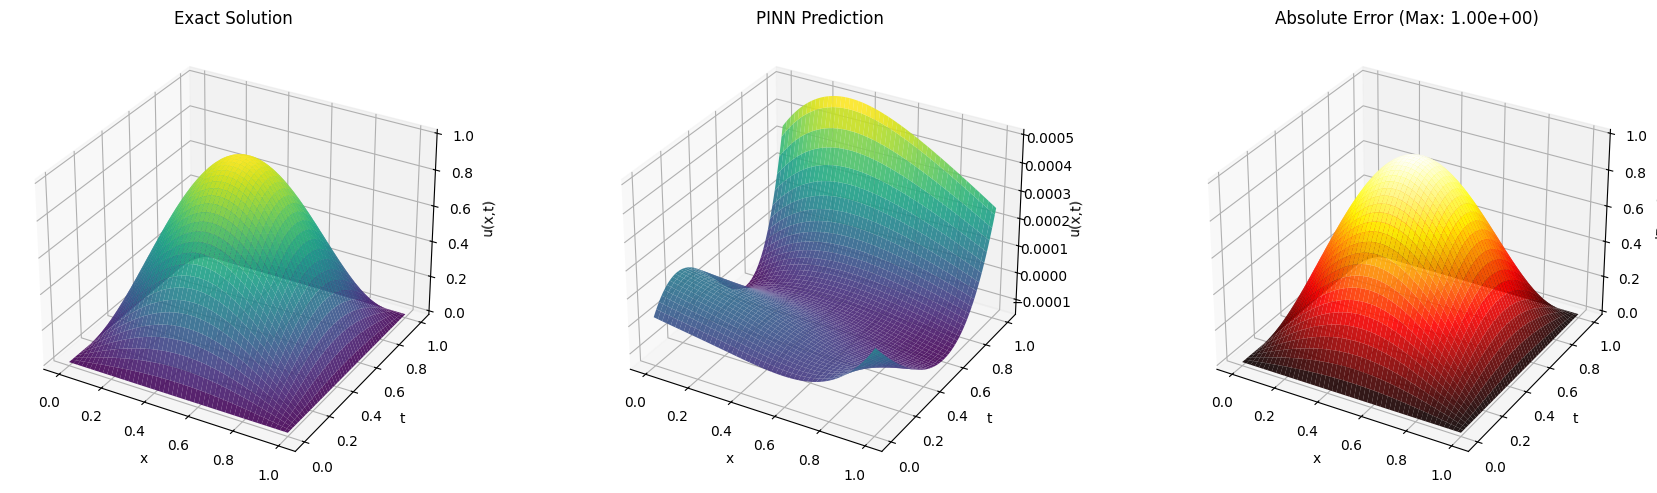


------------------------------------------------------------
Error Statistics
------------------------------------------------------------
Max absolute error:  9.998979e-01
Mean absolute error: 3.991753e-01
L2 relative error:   1.000027e+00
------------------------------------------------------------



In [14]:
import torch
import numpy as np
from PINN import PINNSolver

# ============================================================
# SELECT TEST CASE
# Options:
# "heat", "diffusion", "source", "wave", "burgers", "laplace2D"
# ============================================================

CASE = "laplace2D"   # <--- change this to test another PDE

# ============================================================
# PDE DEFINITIONS
# Each case returns: exact_solution, residual_function, settings
# ============================================================

def case_heat():
    # Heat equation:
    # u_t = u_xx , u(x,0) = sin(pi x)

    def exact(x, t):
        return torch.exp(-np.pi**2 * t) * torch.sin(np.pi * x)

    def residual(x_col, u_t, u_xx):
        return u_t - u_xx

    settings = dict(
        x_min=-1.0, x_max=1.0,
        t_min=0.0, t_max=1.0,
        steps=20000
    )
    return exact, residual, settings


def case_diffusion():
    # Original PDE:
    # u_t - u_xx - f(x,t) = 0
    # where u = e^{-t} sin(pi x)
    # f(x,t) = e^{-t}(sin(pi x) - pi^2 sin(pi x))

    def exact(x, t):
        return torch.exp(-t) * torch.sin(np.pi * x)

    def residual(x_col, u_t, u_xx):
        x = x_col[:, 0:1]
        t = x_col[:, 1:2]
        f = torch.exp(-t) * (torch.sin(np.pi * x) - np.pi**2 * torch.sin(np.pi * x))
        return u_t - u_xx + f

    settings = dict(
        x_min=-1.0, x_max=1.0,
        t_min=0.0, t_max=1.0,
        steps=20000
    )
    return exact, residual, settings


def case_source():
    # u_t = u_xx + sin(pi x)
    # exact solution derived analytically

    def exact(x, t):
        return (1 - torch.exp(-np.pi**2 * t)) * torch.sin(np.pi * x) / (np.pi**2)

    def residual(x_col, u_t, u_xx):
        x = x_col[:, 0:1]
        f = torch.sin(np.pi * x)
        return u_t - u_xx - f

    settings = dict(
        x_min=-1.0, x_max=1.0,
        t_min=0.0, t_max=1.0,
        steps=20000
    )
    return exact, residual, settings


def case_wave():
    # u_tt - u_xx + u_t = 0
    # example exact solution: u = exp(-t) sin(pi x)
    # NOTE: PINN must compute u_tt internally for this to work

    def exact(x, t):
        return torch.exp(-t) * torch.sin(np.pi * x)

    def residual(x_col, u_t, u_xx, u_tt):
        return u_tt - u_xx + u_t

    settings = dict(
        x_min=-1.0, x_max=1.0,
        t_min=0.0, t_max=1.0,
        steps=25000
    )
    return exact, residual, settings


def case_burgers():
    # Burgers equation:
    # u_t + u u_x = (0.01/pi) u_xx
    nu = 0.01 / np.pi

    def exact(x, t):
        xi = x - 4 * t
        return -2 * nu * np.pi * torch.sin(np.pi * xi) / torch.cos(np.pi * xi)

    def residual(x_col, u_t, u_x, u_xx):
        return u_t + u_x * u_x - nu * u_xx

    settings = dict(
        x_min=-1.0, x_max=1.0,
        t_min=0.0, t_max=1.0,
        steps=30000
    )
    return exact, residual, settings


def case_laplace2D():
    # 2D Laplace:
    # u_xx + u_yy = 0

    def exact(x, y):
        return torch.sin(np.pi * x) * torch.sin(np.pi * y)

    def residual(x_col, u_xx, u_yy):
        return u_xx + u_yy

    settings = dict(
        x_min=0.0, x_max=1.0,
        t_min=0.0, t_max=1.0,  # ignored
        steps=20000
    )
    return exact, residual, settings


# ============================================================
# SELECT CASE
# ============================================================

if CASE == "heat":
    exact_solution, pde_equation, config = case_heat()

elif CASE == "diffusion":
    exact_solution, pde_equation, config = case_diffusion()

elif CASE == "source":
    exact_solution, pde_equation, config = case_source()

elif CASE == "wave":
    exact_solution, pde_equation, config = case_wave()

elif CASE == "burgers":
    exact_solution, pde_equation, config = case_burgers()

elif CASE == "laplace2D":
    exact_solution, pde_equation, config = case_laplace2D()

else:
    raise ValueError("Unknown case selected.")


# ============================================================
# CREATE THE PINN SOLVER
# ============================================================

pinn_solver = PINNSolver(
    steps=config["steps"],
    learning_rate=1e-3,
    layers=np.array([2, 32, 32, 1]),
    x_min=config["x_min"],
    x_max=config["x_max"],
    t_min=config["t_min"],
    t_max=config["t_max"],
    total_points_x=200,
    total_points_t=100,
    num_boundary_points=100,
    num_collocation_points=10000,
    pde_equation=pde_equation,
    exact_solution=exact_solution
)

# ============================================================
# TRAIN AND VISUALIZE
# ============================================================

print(f"\n=== Running case: {CASE.upper()} ===\n")

print("Preparing training data…")
pinn_solver.prepare_training_data()

print("Training…")
pinn_solver.train()

print("Generating visualizations...")
pinn_solver.visualize_results()